# imports

In [1]:
%run read_matlab_file.ipynb
%run convert_erg.ipynb
%run safety_time.ipynb

read_matlab_file.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!


# implementation blueprint

    -Problem: Fucked up the pltmacro. Might be caused by the "TkAgg" backend.
    Solution: The pltmacro file is imported correctly but when one is generating plots from another notebook the rcParams in TkAgg backend kicks in.
    
    
    
    GENERAL IMPLEMENTATION STEPS
    ----------------------------    
    
    
    DATA HANDLING
    -------------
    1. Subtract absolute time correction from T0 and tus array
    2. importing calibration coef and coverting to keV
    3. creating dataframe containing data
    4. sorting by adr and then tus
    5. estimating dt between i and i-1 (after sorting by adr and tus)
    6. calculating safety time based on keV and dt
    7. flagging events that have dt <= st AND typ > 1 events.

    LC PRODUCTION
    -----------------
    1. creating LC containing complete photon list. DONE
    2. filtering photon list based on relevant energy interval. HED [350-1500 kev], LED [80-350 kev]. DONE
    3. remove flagged events from the filtered photon list
    4. calculate background for the relevant energy bands 
    5. plotting LC where background is subtracted
    
    
    final step. plot LC of the flagged events only. The ratio between the flagged events / number of counts in each bin is a measure of the dead time. (deadtime relative to binsize) 
    
    
    

# Notes
    --final plots should be done in the current notebook

    - be careful of using is True or is not True. There are two types of booleans: np.bool_ or native python bool
    USE: == or !=
    
    - a lot of energies are converted to keV = 351.4519739
    
    - Flagging all type 3 events or using the algorithm to find it? 116 vs 114
    
    -flagg all type 3 events manually?

# complete df

In [2]:
def complete_df(grb_id):
    if len(trig_dict_HED[grb_id])>1:
        return print("long grb, handle later")
    else:
        tus, erg, typ, adr, dau, det, T0 = read_matlab_file_with_BGO_data(trig_dict_HED[grb_id][0])
        keV,cal_abc = convert_erg(erg, dau, det, T0)
        print("erg converted to keV")
        df = create_df(tus,erg,typ,adr,dau,det,keV,cal_abc)
        df = df.sort_values(by=['adr','tus']) #important to sort first by the adr then tus --> Handling the triggers in each detector seperate
        print("df sorted by adr and tus")
        #Creating columns for st, dt and flag
        st_list = get_st(df)
        df["st"] = st_list
        
        dt_list = get_dt(df)
        df["dt"] = dt_list
        
        flag = get_flag(df) #should also flag fast events!
        df["flag"] = flag
        
        print("safety time events flagged and type = 3 events flagged. " + "Found " + str(sum(df["flag"].to_numpy())) + " flags")
        return df,T0

In [13]:
df,T0 = complete_df("GRB190206")
print(df.shape)
df.head()

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged and type = 3 events flagged. Found 474 flags
(24774, 11)


,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
16,-491943.976667,299,0,1,1,1,2998.481096,"0.004946, 8.3696, 53.79335",12.993924,NaN,False
17,-491803.948889,1815,0,1,1,1,31537.854200,"0.004946, 8.3696, 53.79335",25.615142,140.027778,False
19,-491737.948889,260,0,1,1,1,2564.238950,"0.004946, 8.3696, 53.79335",11.256956,66.000000,False
54,-488456.782222,1057,0,1,1,1,14426.374104,"0.004946, 8.3696, 53.79335",21.000000,3281.166667,False
85,-485219.698889,37,0,1,1,1,370.239624,"0.004946, 8.3696, 53.79335",0.000000,3237.083333,False


# filtering energy interval and removing flagged events

In [4]:
# df is soreted by adr and then tus

def filter_by_energy_interval(df,lower_bound,upper_bound):
    """lower and upper bound given in keV
    IMPROVEMENT: maybe just return the flagged tus here insted of indexing them in the df
    
    return: tus: photon trigger list filtered by energy interval
            kev: array of keV's 
            flagged: array containing the indecies in the df that are in the energy interval and have been flagged"""
    
    tus_arr = df["tus"].to_numpy()
    kev_arr = df["keV"].to_numpy()
    flag_arr = df["flag"].to_numpy()
    
    
    tus_temp, kev_temp, flagged_temp = [],[],[]
    print("selecting kev interval. Removing flagged events.")
    for i,kev in enumerate(kev_arr):
        if lower_bound <= kev <= upper_bound:
            if flag_arr[i] == False:
                kev_temp.append(kev)
                tus_temp.append(tus_arr[i])
            else:
                flagged_temp.append(tus_arr[i])

    print("found {} out of {} flagged triggers on the given keV interval".format(len(flagged_temp), sum(df["flag"])))
    return np.array(tus_temp), np.array(kev_temp), np.array(flagged_temp)
    

# background estimation

In [22]:
def estimate_background(tus,start=None,end=None,binsize=None):
    """Estimates background for a given tus array on a given ms interval.
    Using histograms for estimation. 
    -Constant fit: sum(bin counts)/length(bins)
    -Binsize given in ms. USING BINS ESTIMATED FROM TUS FOR ALL OTHER LC'S!
    -indexing of the bins hist[start_idx, end_idx) >> up to but not including the end_idx bin
    """
 
    
    if binsize == None:
        return print("binsize need to be specified")
    
    hist = np.histogram(tus/1e3,bins=np.arange(
            min(tus/1e3), max(tus/1e3) + binsize, binsize)) #binning in ms not us
    
    hist_bg = hist[0]
    edges = hist[1] #array of position the hist bin start
    
    if start=="start" or start==None:
        start_idx = 0
    else:
        start_idx = find_nearest(edges,start)
        
    if end == None:
        return print("end index need to be specified")
    else:
        end_idx = find_nearest(edges,end)
        bg = round(sum(hist_bg[start_idx:end_idx])/len(hist_bg[start_idx:end_idx]))
        print("bg avg on interval:", bg)
        #bg = 220
        hist_no_bg = hist_bg - bg #subtracting background all bins.
        
    return hist_bg, hist_no_bg, edges, bg

In [6]:
def estimate_dead_time(tus_filt_hist=None,tus_flagged_hist=None):
    '''defined as the the ratio between the counts in the filtered (or the normal array) / removed bins
    generating the ratio between the normal and filtered hists
    
    
    NOTE: binning based on the TUS_FILT array.
    
    estimate the ratio between the number of flagged events vs filtered counts in each bin. 
    how to estimate dead time? 
    
    return the ratio pr bin as an array'''
    
    dead_time_temp =[]
    
    for i,n in enumerate(tus_flagged_hist):
        if tus_filt_hist[i]==0:
            dead_time_temp.append(0)
        else:
            fraq = np.round(n/tus_filt_hist[i],5)
            dead_time_temp.append(fraq)
        
    return np.array(dead_time_temp)
    

# main filter 

In [23]:
#change name to main()
def main_filter(grb_id=None, lower_bound=None, upper_bound=None, start=None, end=None, binsize=None):
    '''Need plots for original image, filtered energy range with background marked, filtered with background removed
    
    returns: filtered histogram, edges and background

    '''
    #data handling
    df,T0 = complete_df(grb_id)
    
    #regular tus array
    tus = df["tus"].to_numpy()
    org_hist, org_edges = np.histogram(tus/1e3,bins=np.arange(min(tus/1e3), max(tus/1e3) + binsize, binsize))
    
    #filtered arrays
    tus_filt, kev_filt, tus_flagged = filter_by_energy_interval(df,lower_bound,upper_bound)
    
    #histogram binning
    hist_bg, hist_no_bg, edges, bg = estimate_background(tus_filt,start=start,end=end,binsize=binsize)
    flagged_hist, flagged_edges = np.histogram(tus_flagged/1e3,bins=np.arange(min(tus/1e3), max(tus/1e3) + binsize, binsize))
    
    #deadtime 
    #dead_time = estimate_dead_time(tus_filt_hist=hist_no_bg,tus_flagged_hist=flagged_hist)
    
    return org_hist, hist_bg, hist_no_bg, flagged_hist, org_edges, bg, binsize
    

In [24]:
org_hist, hist, hist_no_bg, flagged_hist, org_edges, bg, binsize = main_filter(grb_id="GRB200415",lower_bound=350,upper_bound=1500,start=-750,end=-20,binsize=2)

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged and type = 3 events flagged. Found 303 flags
selecting kev interval. Removing flagged events.
found 101 out of 303 flagged triggers on the given keV interval
bg avg on interval: 6


# plotting functions

In [50]:
def LC_plots(org_hist, hist, hist_no_bg, flagged_hist, edges, bg, binsize):
     # Producing LC
    #to silence an axis for odd number of plots: ax[-1, -1].axis('off')
    fig, (ax1,ax2) = plt.subplots(2,2,sharey=True,figsize=(16,10))
    

    ax1[0].bar(x=edges[:-1], height=org_hist, width=binsize, edgecolor="black",align='edge',color="black",label="Full photon list")
    
    ax1[1].bar(x=edges[:-1], height=hist, width=binsize, edgecolor= "black",align='edge', color="black", label="Energy range {}-{} keV".format(lower_bound,upper_bound))

    ax1[1].axhline(bg,c="r",label="Background: {} counts/bin \n Background interval [{},{}] ms".format(bg,start,end))
    
    ax2[0].bar(edges[:-1], hist_no_bg ,width=binsize, edgecolor="black", align='edge',color="black", label="Background subtracted. \n Filter: {}-{} keV".format(lower_bound,upper_bound))

    ax2[1].bar(x=edges[:-1], height=flagged_hist, width=binsize, edgecolor="black", align='edge',color="black", label="flagged events")
    
    #setting X/Y labels and legends
    for i in np.arange(0,2):
            ax1[i].set_xlabel("T-T0 [ms], binsize = {} ms".format((binsize)))
            ax1[i].set_ylabel("Counts/ {} ms".format((binsize)))
            ax1[i].legend()
    for i in np.arange(0,2):
            ax2[i].set_xlabel("T-T0 [ms], binsize = {} ms".format((binsize)))
            ax2[i].set_ylabel("Counts/ {} ms".format((binsize)))
            ax2[i].legend()
    
    #setting titles for figure and subfigures
    date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
    time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12]
    grb_id_title = "GRB " + date_id
    plt.suptitle(grb_id_title + " , " + "T0 = " + time_id)
    ax1[0].set_title("Complete photon array")
    ax1[1].set_title("Filtered by energy interval with background")
    ax2[0].set_title("Filtered by energy interval without background")
    ax2[1].set_title("Flagged events on energy interval")
                                                
    plt.tight_layout()
    plt.show()

In [53]:
org_hist, hist, hist_no_bg, flagged_hist, org_edges, bg, binsize = main_filter(grb_id="GRB190206",lower_bound=350,upper_bound=1500,start=-750,end=-20,binsize=2)

Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged and type = 3 events flagged. Found 474 flags
selecting kev interval. Removing flagged events.
found 141 out of 474 flagged triggers on the given keV interval
bg avg on interval: 10


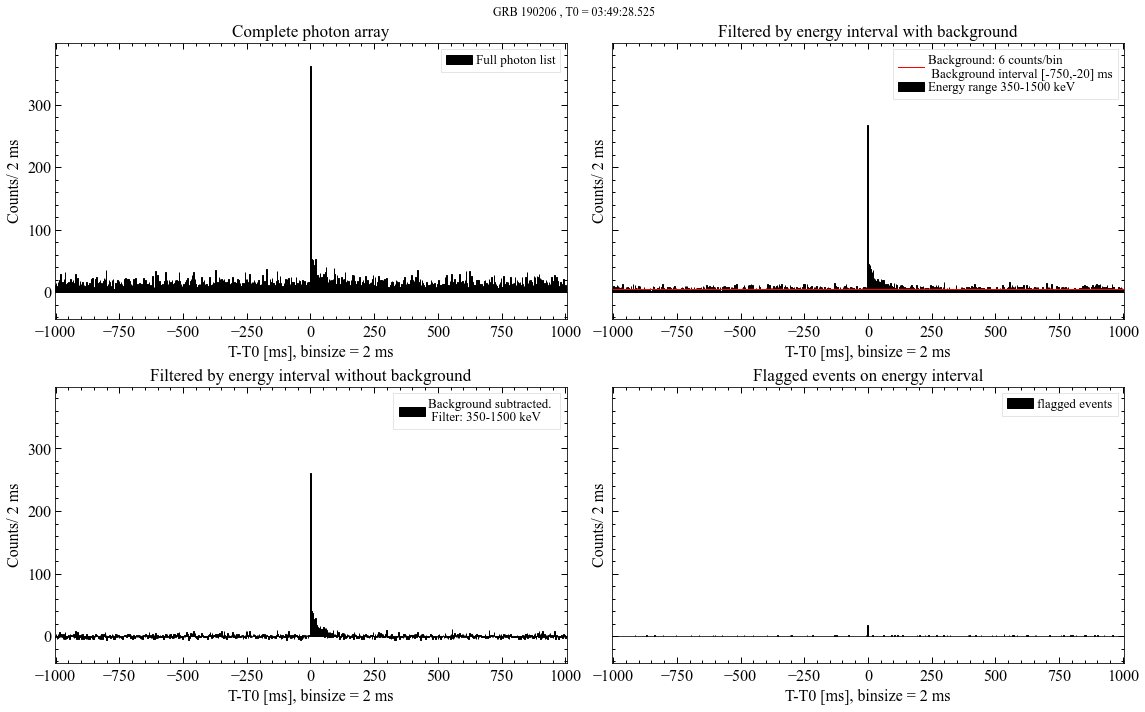

In [51]:
LC_plots(org_hist, hist, hist_no_bg, flagged_hist, org_edges, bg, binsize)

In [9]:
df,T0 = complete_df(grb_id="GRB200415")
start=-750
end=-20
lower_bound=350
upper_bound=1500
binsize=2
    
#regular tus array
tus = df["tus"].to_numpy()

#filtered arrays
#changed flagged_idx to tus_flagged
tus_filt, kev_filt, tus_flagged = filter_by_energy_interval(df,lower_bound,upper_bound)


#histogram binning
hist, hist_bg, edges, bg = estimate_background(tus_filt,start=start,end=end,binsize=binsize)
flagged_hist,flagged_edges = np.histogram(tus_flagged/1e3,bins=np.arange(
        min(tus_flagged/1e3), max(tus_flagged/1e3) + binsize, binsize))


dead_time = estimate_dead_time(tus_filt_hist=hist_bg,tus_flagged_hist=flagged_hist)


Absolute time correction subtracted from tus array and T0
erg converted to keV
df sorted by adr and tus
safety time events flagged and type = 3 events flagged. Found 303 flags
selecting kev interval. Removing flagged events.
found 101 out of 303 flagged triggers on the given keV interval
bg avg on interval: 6


In [52]:
# we assume the dead time is negligible. We dont have a good model for estimating the dead time yet.